Supervised Principal Component Analysis: Visualization, Classification and Regression on Subspaces and Submanifolds

https://uwaterloo.ca/data-analytics/sites/ca.data-analytics/files/uploads/files/barshan_supervised_preprint.pdf

In [2]:
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import eigsh as ssl_eigsh

In [3]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import utils
from sklearn.preprocessing import KernelCenterer, scale
from sklearn.metrics.pairwise import pairwise_kernels

# Algorithm: Supervised PCA

Input: training data matrix, X, testing data example, x, kernel matrix of target variable, L, and training data size, n.

Onput: Dimension reduced training and testing data, Z and z.

1: H ← I − (n^−1)ee^T

2: Q ← XHLHX^T

3: Compute basis: U ← eigenvectors of Q corresponding to the top d eigenvalues.

4: Encode training data: Z ← U^T X

5: Encode test example: z ← U^T x

In [4]:
class spca(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_components, kernel="linear", eigen_solver='auto', 
                 max_iterations=None, gamma=0, degree=3, coef0=1, alpha=1.0, 
                 tolerance=0, fit_inverse_transform=False):
        
        self._num_components = num_components
        self._gamma = gamma
        self._tolerance = tolerance
        self._fit_inverse_transform = fit_inverse_transform
        self._max_iterations = max_iterations
        self._degree = degree
        self._kernel = kernel
        self._eigen_solver = eigen_solver
        self._coef0 = coef0
        self._centerer = KernelCenterer()
        self._alpha = alpha
        
        
    def _get_kernel(self, X, Y=None):
        # Returns a kernel matrix K such that K_{i, j} is the kernel between the ith and jth vectors 
        # of the given matrix X, if Y is None. 
        
        # If Y is not None, then K_{i, j} is the kernel between the ith array from X and the jth array from Y.
        
        # valid kernels are 'linear, rbf, poly, sigmoid, precomputed'
        
        args = {"gamma": self._gamma, "degree": self._degree, "coef0": self._coef0}
        
        return pairwise_kernels(X, Y, metric=self._kernel, n_jobs=-1, filter_params=True, **args)
    
    
    
    def _fit(self, X, Y):
        
        # calculate kernel matrix of the labels Y and centre it and call it K (=H.L.H)
        K = self._centerer.fit_transform(self._get_kernel(Y))
        
        # deciding on the number of components to use
        if self._num_components is not None:
            num_components = min(K.shape[0], self._num_components)
        else:
            num_components = self.K.shape[0]
        
        # Scale X
        # scaled_X = scale(X)
        
        # calculate the eigen values and eigen vectors for X^T.K.X
        Q = (X.T).dot(K).dot(X)
        
        # If n_components is much less than the number of training samples, 
        # arpack may be more efficient than the dense eigensolver.
        if (self._eigen_solver=='auto'):
            if (Q.shape[0]/num_components) > 20:
                eigen_solver = 'arpack'
            else:
                eigen_solver = 'dense'
        else:
            eigen_solver = self._eigen_solver
        
        if eigen_solver == 'dense':
            # Return the eigenvalues (in ascending order) and eigenvectors of a Hermitian or symmetric matrix.
            self._lambdas, self._alpha = linalg.eigh(Q, eigvals=(Q.shape[0] - num_components, Q.shape[0] - 1))
            # argument eigvals = Indexes of the smallest and largest (in ascending order) eigenvalues
        
        elif eigen_solver == 'arpack':
            # deprecated :: self._lambdas, self._alpha = utils.arpack.eigsh(A=Q, num_components, which="LA", tol=self._tolerance)
            self._lambdas, self._alpha = ssl_eigsh(A=Q, k=num_components, which="LA", tol=self._tolerance)
            
        indices = self._lambdas.argsort()[::-1]
        
        self._lambdas = self._lambdas[indices]
        self._lambdas = self._lambdas[self._lambdas > 0]  # selecting values only for non zero eigen values
        
        self._alpha = self._alpha[:, indices]
        self._alpha = self._alpha[:, (self._lambdas > 0)]  # selecting values only for non zero eigen values
        
        self.X_fit = X

        
    def _transform(self):
            return self.X_fit.dot(self._alpha)
        
        
    def transform(self, X):
            return X.dot(self._alpha)
        
        
    def fit(self, X, Y):
            self._fit(X,Y)
            return
        
        
    def fit_and_transform(self, X, Y):
            self.fit(X, Y)
            return self._transform()
               

        

In [5]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [6]:
train_X.shape 

(60000, 28, 28)

In [31]:
trial_X = train_X[0:30000,:,:].reshape((-1,784))
trial_y = train_y[0:30000].reshape((-1,1))

trial_X.shape

(30000, 784)

In [32]:
pca = spca(num_components = 16)
pca.fit(trial_X, trial_y)

In [33]:
X = pca.transform(trial_X)
X.shape

(30000, 16)

In [34]:
import tensorflow as tf
dnny_train = tf.keras.utils.to_categorical(trial_y)
dnny_test = tf.keras.utils.to_categorical(test_y)

In [42]:
import keras as K
model = K.models.Sequential()
model.add(K.layers.Dense(units=50, input_dim=16,
  activation='relu'))
model.add(K.layers.Dense(units=150,
  activation='relu'))
model.add(K.layers.Dense(units=300,
  activation='relu'))
model.add(K.layers.Dense(units=200,
  activation='relu'))
model.add(K.layers.Dense(units=70,
  activation='relu'))
model.add(K.layers.Dense(units=10,
  activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 50)                850       
                                                                 
 dense_19 (Dense)            (None, 150)               7650      
                                                                 
 dense_20 (Dense)            (None, 300)               45300     
                                                                 
 dense_21 (Dense)            (None, 200)               60200     
                                                                 
 dense_22 (Dense)            (None, 70)                14070     
                                                                 
 dense_23 (Dense)            (None, 10)                710       
                                                                 
Total params: 128,780
Trainable params: 128,780
Non-tr

In [46]:
num_epochs = 10
h = model.fit(X, dnny_train, batch_size=50, epochs=num_epochs, verbose= 0) 

In [47]:
h.history

{'loss': [0.3312532901763916,
  0.3111935555934906,
  0.29774126410484314,
  0.28123417496681213,
  0.2706436812877655,
  0.26320886611938477,
  0.2439946085214615,
  0.24072745442390442,
  0.22957895696163177,
  0.21088118851184845],
 'accuracy': [0.885200023651123,
  0.8918666839599609,
  0.8969666957855225,
  0.902899980545044,
  0.9045000076293945,
  0.9072333574295044,
  0.9133999943733215,
  0.9171666502952576,
  0.9199000000953674,
  0.9256333112716675]}

In [48]:
eval = model.evaluate(pca.transform(test_X.reshape((-1,784))), dnny_test, verbose=0)
print("\nEvaluation on test data: \nloss = %0.4f \
    accuracy = %0.2f%%" % (eval[0], eval[1]*100) )

print("\nEnd MNIST DNN demo \n")


Evaluation on test data: 
loss = 0.9128     accuracy = 78.97%

End MNIST DNN demo 



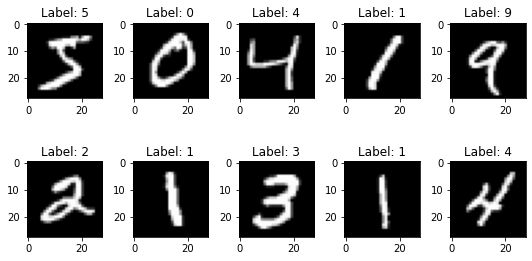

In [55]:
import matplotlib.pyplot as plt

num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(train_X[i], cmap='gray')
    ax.set_title('Label: {}'.format(train_y[i]))
plt.tight_layout()
plt.show()